
# Visualizing gesture kinematic spaces

![](./images/envision_banner.png)

## Info documents

* location Repository: https://github.com/WimPouw/envisionBOX_modulesWP/tree/main/gesture_kinematic

* location Jupyter notebook: https://github.com/WimPouw/envisionBOX_modulesWP/blob/main/MultimodalMerging/gesture_kinematic_spaces.ipynb

*  Pouw, W. (2023). Visualizing gesture kinematic spaces. [the day you viewed the site]. Retrieved from: https://envisionbox.org/gesture_kinematic_spaces.html

## Background
Human (communicative) body movements are often recurrent, such that they use similar shapes or trajectories to convey or act on something consistently. How can we make sense of the variability and consistency with which movement events are produced? One way to do this is by quantifying the similarities present between all the produced movement events. Once we have documented how similar each movement event is relative to all other events, we can then visualize and quantify the structure of these interrelationships and discover novel patterns that exist over the entire set of behaviors. For example, in previous work we have found that when communicative silent gestures have been practiced and communicated more, those silent gestures start to change their interrelationships in consistent ways (e.g., the kinematic space reduces in complexity) (see [3] Pouw, Dingemanse, Motamedi, Ozyurek, 2021).

Note that this particular procedure outlined here, is introduced in [1] Pouw & Dixon (2020) and we advise you to read this first before starting (or [3]). The main procedure: we compute some distance measure between two N-dimenionsal time series *i* and *j*, and do this for all events *n*. Similar to previous work [1] we will use dynamic time warping (see [2] Giorgino, 2009) as the distance calculation. We then compute what is called a distance matrix (**M**) which has *n* rows and *n* columns containing for each cell M[*i*,*j*] the distance score between movement *i* and *j*. Then we can use dimensional reduction techniques (e.g., classic multidimenionsal scaling, t-sne, UMAP, PCA) to visualize in 2-dimensional space the interrelationships between all movement events.

For the current movement events we use a set of silent gestures produced by an actor conveying certain concepts (open dataset by: [4][Ortega & Ozyurek, 2020). We extracted the movement information using mediapipe 3D body tracking for each silent gesture, and this is the input of our procedure. Note that the current procedure can be applied on any signal (e.g., acoustic trajectories) and also on multiple persons that are producing movement events.


## Overview processing steps

This markdown file contains the following processing steps.

* Create a distance matrix with dynamic time warping distances between events

* Visualize the distance matrix in a 2D space

In [1]:
# loading in some basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import html
import os


# initializing some folders and files
timeseriesfolder = "../TimeSeries/"
distancematrixfolder = "../Distance_matrices/"
videofolder = "../Videos/WithMotionTracking/"

The folder 'TimeSeries' is filled with mediapipe body tracking time series for each video. We extract from it, nose, elbow, index finger (x , y, z) info (for both hands). Figure 1 shows an example of the kinematic time series for the silent gesture "TO-SWIM" which is also shown below. The swimming gesture has a characteristic rhythmic movement, as reflected in the oscillating movements in the horizontal dimension for left and right index finger. 





Figure 1. Example raw time series of SWIMMING for the right (red) and left hand (in blue)

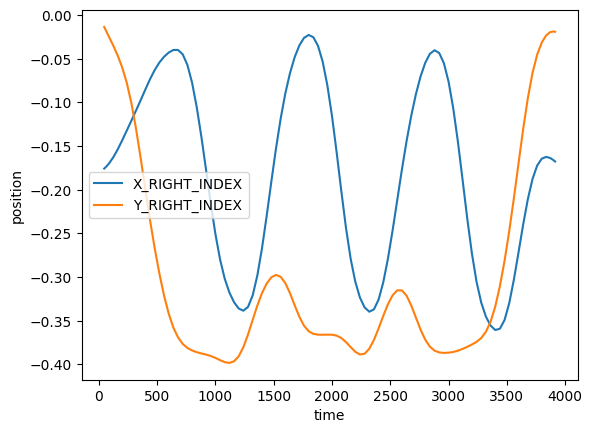

In [2]:
from IPython.display import Image
from scipy.ndimage import gaussian_filter1d

#load in data
MT = pd.read_csv(timeseriesfolder+"TO-SWIM_silentgesture.csv")
MT = MT.apply(lambda x: gaussian_filter1d(x, sigma = 2)) #smooth a little
#plot X_RIGHT_INDEX and Y_RIGHT_INDEX time series with time as x-axis
plt.plot(MT['time'], MT['X_RIGHT_INDEX'], label='X_RIGHT_INDEX')
plt.plot(MT['time'], MT['Y_RIGHT_INDEX'], label='Y_RIGHT_INDEX')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.show()

# show gif
Image(url="./images/TO-SWIM.gif")

## Main routine: constructing a distance matrix

The next step is to compute a average dynamic time warping distance between joint position traces. This means we are performing a dependent DTW (using fast-dtw), where x,y,z time series are submitted for DTW comparison for a gesture *i* and gesture event *j*, and we perform this procedure for each joint separately (this averaging of by-keypoint DTW comparisons is called an independent DTW; so we are combining an independent and dependent DTW version).

In [9]:
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import SlopeDescriptor
from scipy.ndimage import gaussian_filter1d

#identify which column indices in a dataframe correspond to which body parts
kkeypointindexright =  ["X_RIGHT_INDEX_FINGER_TIP", "Y_RIGHT_INDEX_FINGER_TIP", "Z_RIGHT_INDEX_FINGER_TIP"]
keypointindexleft = ["X_LEFT_INDEX_FINGER_TIP", "Y_LEFT_INDEX_FINGER_TIP", "Z_LEFT_INDEX_FINGER_TIP"]
keypointelbowright = ["X_RIGHT_ELBOW", "Y_RIGHT_ELBOW", "Z_RIGHT_ELBOW"]
keypointelbowleft = ["X_LEFT_ELBOW", "Y_LEFT_ELBOW", "Z_LEFT_ELBOW"]
keypointshoulderright = ["X_RIGHT_SHOULDER", "Y_RIGHT_SHOULDER", "Z_RIGHT_SHOULDER"]
keypointshoulderleft = ["X_LEFT_SHOULDER", "Y_LEFT_SHOULDER", "Z_LEFT_SHOULDER"]
#added:
keypointwristright = ["X_RIGHT_WRIST", "Y_RIGHT_WRIST", "Z_RIGHT_WRIST"]
keypointwristleft = ["X_LEFT_WRIST", "Y_LEFT_WRIST", "Z_LEFT_WRIST"]
keypointpinkyright =  ["X_RIGHT_PINKY_FINGER_TIP", "Y_RIGHT_PINKY_FINGER_TIP", "Z_RIGHT_PINKY_FINGER_TIP"]
keypointpinkyleft = ["X_LEFT_PINKY_FINGER_TIP", "Y_LEFT_PINKY_FINGER_TIP", "Z_LEFT_PINKY_FINGER_TIP"]
keypointthumbright = ["X_RIGHT_THUMB_TIP", "Y_RIGHT_THUMB_TIP", "Z_RIGHT_THUMB_TIP"]
keypointthumbleft = ["X_LEFT_THUMB_TIP", "Y_LEFT_THUMB_TIP", "Z_LEFT_THUMB_TIP"]

# make one 1 list with all keypoints
keypoints = keypointindexright + keypointindexleft + keypointelbowright + keypointelbowleft + keypointshoulderright + keypointshoulderleft

#dtw init
slope_descriptor = SlopeDescriptor(slope_window=3)
subsequence_width = 3

#make a function that takes in two timeseries and produces a normalized dtw distance
def dtw_distance(ts1, ts2):
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)
    #now calculate a multidimesnional (dependent) dtw distance using dtwParallel Multivariate = true, type dtw = dependent, distance is euclidean, compare the two timeseries only locally (sakoe_chiba)
    res = shape_dtw(x = ts1, y = ts2, subsequence_width=subsequence_width,shape_descriptor=slope_descriptor, multivariate_version="dependent")
    distance = res.normalized_distance
    return distance

# make a dependent dtw such that each keypoint dtw distance is added up
def dtw_distance_dependent(MT1, MT2):
    disleftindex = dtw_distance(MT1[keypointindexleft], MT2[keypointindexleft])
    disrightindex = dtw_distance(MT1[keypointindexright], MT2[keypointindexright])
    disleftelbow = dtw_distance(MT1[keypointelbowleft], MT2[keypointelbowleft])
    disrightelbow = dtw_distance(MT1[keypointelbowright], MT2[keypointelbowright])
    disleftshoulder = dtw_distance(MT1[keypointshoulderleft], MT2[keypointshoulderleft])
    disrightshoulder = dtw_distance(MT1[keypointshoulderright], MT2[keypointshoulderright])
    #added
    disleftwrist = dtw_distance(MT1[keypointwristleft], MT2[keypointwristleft])
    disrightwrist = dtw_distance(MT1[keypointwristright], MT2[keypointwristright])
    disleftpinky = dtw_distance(MT1[keypointpinkyleft], MT2[keypointpinkyleft])
    disrightpinky = dtw_distance(MT1[keypointpinkyright], MT2[keypointpinkyright])
    disleftthumb = dtw_distance(MT1[keypointthumbleft], MT2[keypointthumbleft])
    disrightthumb = dtw_distance(MT1[keypointthumbright], MT2[keypointthumbright])
    
    #also compute a distance between hands
    disbetweenhands = dtw_distance(np.array((MT1[keypointindexleft])-np.array(MT1[keypointindexright])), (np.array(MT2[keypointindexleft])-np.array(MT2[keypointindexright])))
    # return the mean distance
    return (disleftindex + disrightindex + disleftelbow + disrightelbow + disleftshoulder + disrightshoulder + disleftwrist + disrightwrist + disleftpinky + disrightpinky + disleftthumb + disrightthumb) / 13


27
45
3.28


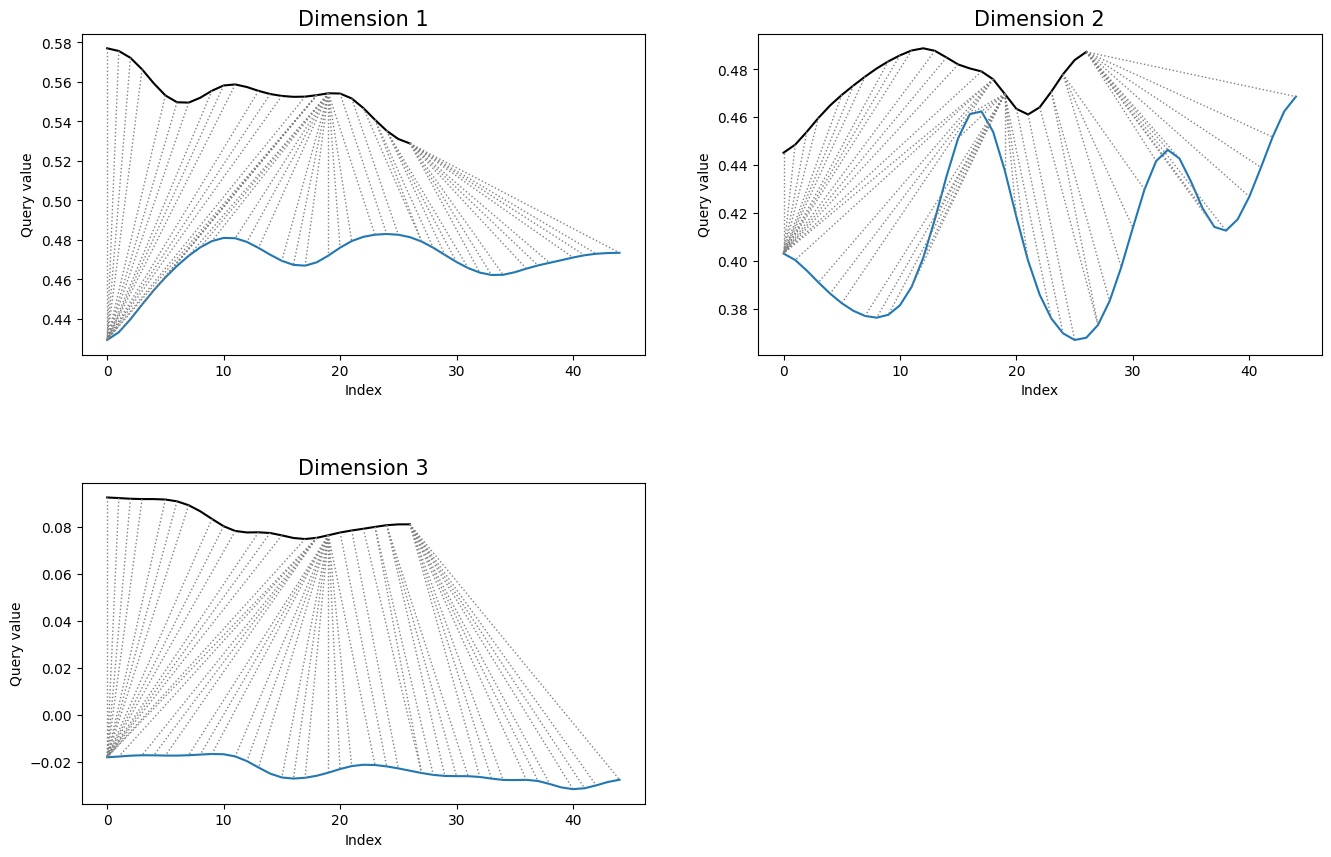

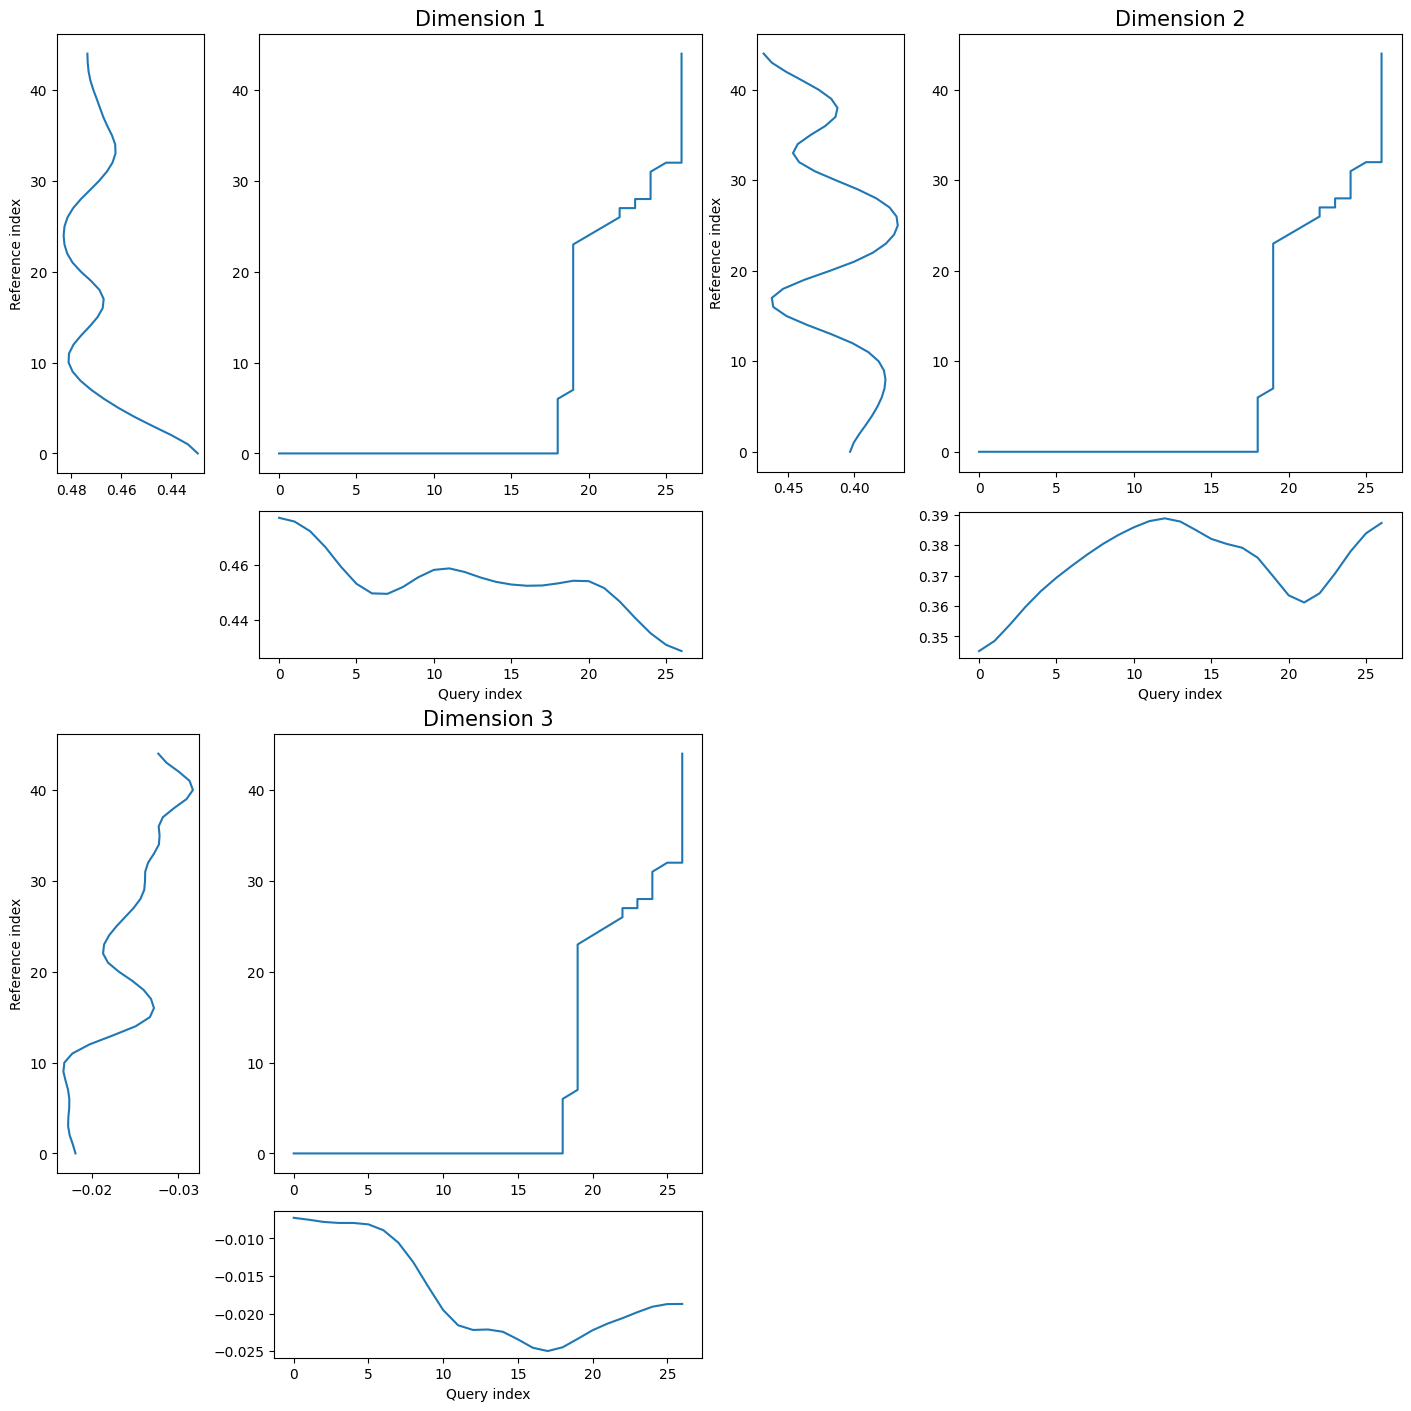

In [17]:

# Read up on shape DTW here
# https://mikolajszafraniecupds.github.io/shapedtw-python/
import numpy as np
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.dtwPlot import dtwPlot
from shapedtw.shapeDescriptors import SlopeDescriptor

# using dtw to compare distances and show a warping line
MT1 = pd.read_csv(timeseriesfolder+"CHIUDERE_LIS_06_CT_Ad_merged.csv")
MT2 = pd.read_csv(timeseriesfolder+"CHIUDERE_LIS_06_CT_Ch_merged.csv")
MT1 = MT1.apply(lambda x: gaussian_filter1d(x, sigma = 2)) #smooth a little
MT2 = MT2.apply(lambda x: gaussian_filter1d(x, sigma = 2)) #smooth a little

# see two time series  MT1["Y_RIGHT_INDEX"] and MT2["Y_RIGHT_INDEX"] into np.array
ts1 = np.array(MT1[keypointpinkyright])
ts2 = np.array(MT2[keypointpinkyright])
print(len(ts1))
print(len(ts2))
# produce dtw distance dtaidistance.dtw_ndim.distance
#dtw_functions.dtw(ts1, ts2, local_dissimilarity=d.euclidean, get_visualization=True, constrained_path_search="sakoe_chiba")

slope_descriptor = SlopeDescriptor(slope_window=2)
subsequence_width = 3

shape_dtw_dependent_results = shape_dtw(
    x=ts1,
    y=ts2,
    subsequence_width=subsequence_width,
    shape_descriptor=slope_descriptor,
    multivariate_version="dependent" 
)
dependent_distance = round(shape_dtw_dependent_results.distance, 2)
print(dependent_distance)
dtwPlot(shape_dtw_dependent_results, plot_type="twoway", xoffset=0.1)
dtwPlot(shape_dtw_dependent_results, plot_type="threeway")

## Main routine: constructing a distance matrix

The next step is to compute a average dynamic time warping distance between joint position traces. This means we are performing a dependent DTW, where x,y,z time series are submitted for dependent DTW comparison for a gesture *i* and gesture event *j*, and we perform this procedure for each joint separately (this averaging of by-keypoint DTW comparisons is called an independent DTW; so we are combining an independent and dependent DTW version).

In [11]:
# First identify the number of different time series csv files we have in the data folder timeseriesfolder
ts_objloc = os.listdir(timeseriesfolder)
num_ges = len(ts_objloc)
print("Number of gesture files: ", num_ges)

# Load all gesture files into a dictionary
gesture_data = {}
gesture_names = []
for i, objloc in enumerate(ts_objloc):
    ges_i = pd.read_csv(timeseriesfolder + objloc, sep=',')
    #lets filter the time series
    ges_i = ges_i.apply(lambda x: gaussian_filter1d(x, sigma = 2))
    gesture_data[i] = ges_i[keypoints] #only keep the relevant columns
    # what gesture is this
    name = objloc.replace("silent_gesture.csv", "")
    gesture_names.append(name)

print("Loaded", len(gesture_data), "gesture files and smoothed them")

Number of gesture files:  111


KeyError: "['X_LEFT_INDEX_FINGER_TIP', 'Y_LEFT_INDEX_FINGER_TIP', 'Z_LEFT_INDEX_FINGER_TIP'] not in index"


Note that this takes some time to compute (60 minutes) in the below implementation (ideally you would implement this using a parrelel computing procedure). But this code is much better to comprehend, so we will leave that optimization.

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm  # Import the tqdm library for the progress bar

# Initialize a matrix to store for each gesture comparison the dtw distance
dtw_dist = np.zeros((num_ges, num_ges))

# Loop over all gesture files
for i in tqdm(range(num_ges), desc="Processing gestures", unit="gesture"):
    # Read the i-th gesture file
    ges_i = gesture_data[i]

    # Loop over all gesture files
    for j in range(num_ges):
        # Check if dtw_dist already has a value for the i-th and j-th gesture
        if dtw_dist[i, j] == 0 & (i != j):
            # Read the j-th gesture file
            ges_j = gesture_data[j]

            # Compute the dtw distance between the i-th and j-th gesture
            distance = dtw_distance_dependent(ges_i, ges_j)
            dtw_dist[i, j] = distance

# After the computation is finished, dtw_dist will be populated with all the distances

# save as dtwdist as csv
np.savetxt(distancematrixfolder+'distance_matrix_python.csv', dtw_dist, delimiter=',')

# Dimensionity reduction to get a "kinematic space"

In [10]:
#from sklearn.manifold import MDS
import umap.umap_ as umap #pip install umap-learn

# load in the metadata that we will collect some info from
metadata = pd.read_csv("../IconicityRatings/Iconicity_ratings.csv", sep=',')
# also change the English column so that that spaces become dashes
metadata['English'] = metadata['English'].str.replace(' ', '-')

# Read the distance matrix from the CSV file
dtw_dist = np.genfromtxt(distancematrixfolder+'distance_matrix_python.csv', delimiter=',')

# Assuming your distance matrix is stored in 'distance_matrix'
# Adjust 'n_components' based on how many dimensions you want to project to (in this case, 2D)
# higher value of n_neighbors will lead to more global structure (less extreme clustering)
n_components = 2
umap_model = umap.UMAP(n_components=n_components, n_neighbors=15)
pos = umap_model.fit_transform(dtw_dist)

for i, obj in enumerate(gesture_names):
    #get x, y data
    posix = pos[i][0]
    posiy = pos[i][1]
    # remove from obj a substring 'silent_gesture.csv'
    obj = obj.replace('_silentgesture.csv', '')
    print(obj)
    print(posix, posiy)
    #check if the English column matches the obj
    if metadata['English'].str.contains(obj).any():
        # if it does, then add the posix and posiy values to the data frame
        metadata.loc[metadata['English'] == obj, 'x'] = posix
        metadata.loc[metadata['English'] == obj, 'y'] = posiy
    if not metadata['English'].str.contains(obj).any():
        print('we could not match the following gesture to the metadata: ', obj)

# Save the metadata pd frame for the dashboard
metadata.to_csv('./Dashboard/Assets/main.csv', index=False)

BABY
1.5100409 2.1147745
TO-RUN
11.860918 -0.4699369
CALCULATOR
-0.6201129 1.3070397
TO-SPEAK
0.5279194 0.7760558
BEER
0.4153137 0.70523775
TO-CUT_knife
-1.104534 1.7187586
we could not match the following gesture to the metadata:  TO-CUT_knife
UMBRELLA
11.754037 -1.4766588
WINDSCREENWIPERS
0.6034712 -0.116458856
TELEPHONE
1.5411845 2.358452
STAIRS
-0.16645509 0.68264896
TEA
-0.52222884 0.38623905
TO-GO-UP
-0.453912 0.68705946
TO-PULL
13.429584 -0.4342007
MONKEY
-0.46661785 2.604498
TO-GO-DOWN
1.9518276 2.2716768
KEY
0.9564775 0.51606727
PENGUIN
13.908027 -0.58755356
BED
1.1257894 0.13390051
DOOR
-1.180131 1.1604444
MOTORBIKE
-0.54895955 2.5259829
TO-HAMMER
-0.7442329 2.345285
TO-KNOCK
14.130874 -0.3320382
PLANE
-0.92510283 1.8838831
TO-SLEEP
1.349134 2.312903
PYRAMID
10.811864 -1.3491421
TO-CRASH
-0.2158792 0.31926873
TO-KNEAD
12.9759865 -0.27651322
LOBSTER
12.720334 0.3840024
BUILDING
1.0256785 0.82753634
WHEELCHAIR
12.580275 0.05275437
SCREWDRIVER
1.3775171 0.6211569
LAPTOP
0.265983

In [11]:
# make a dashboard of the results
metadata.head()


,English,Dutch,No. participants,Mode of rep,Semantical category,pp01,pp02,pp03,pp04,pp05,...,pp12,pp13,pp14,pp15,pp16,pp17,pp18,MEAN,x,y
0,TO-FLY,VLIEGEN,20,personification,Action without object,2,1,4,6,6,...,5,5,6,2,5,5,6,4.94,10.922239,-1.389993
1,TO-SWIM,ZWEMMEN,19,acting,Action without object,7,6,7,7,7,...,7,7,7,7,6,7,7,6.89,13.588408,-0.336096
2,HOUSE,HUIS,17,drawing,Non-manipulable object,5,2,3,6,5,...,4,6,5,3,3,3,3,4.67,0.682834,-0.530502
3,TO-WRING,WRINGEN,20,acting,Action with object,6,5,3,7,4,...,7,6,5,5,4,6,5,5.67,2.246192,1.628603
4,TO-SHOUT,SCHREEUWEN,11,acting,Action without object,7,6,4,6,7,...,6,7,7,5,7,6,5,6.28,12.506014,-0.011612
